# Introduction

- Provide a project overview and a clear problem description, including a history of how the problem came about and why the problem is important/interesting.
- Describe how you acquired the data and provide a concise summary of any cleaning steps taken (i.e., summarize how you cleaned the data in the  pre-processing notebook).
- Give an outline of the rest of the report and list any key assumptions made to simplify problems.
- Briefly summarize your overall approach.

The Design Innovation Lab has a series of 3D printers utilized by everyone from InterEGR 170 to PhD researchers. Over the years, the space has accumulated many different printers aligned with different use cases. As well, staff must maintain and help users print on these printers. This brings about two questions: (1) what are the use cases and segments of customers that use the printers, and (2) when do they need help from staff. This question can help the space effectively identify new printers to purchase, as well as when to staff more or less employees. 

In [10]:
#Import Statements
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

We acquired the data directly as Marley is an employee of the Design Innovation Lab. As for data cleaning we dropped rows with null values as it would be hard to work with rows that have null values. We also dropped a duplicate column that was named ‘Print ID’ as it would skew our data analysis. We also dropped many rows that weren’t necessary to what we were trying to find. Things such as if they needed help from staff, if they had subitems, what their job status is, tracking of the print process, the materials people requested, links and IP addresses, status of the printers, if they are doing it for a course/org, instructions, material items, agreements and understanding, if any archive data was needed, print counts, payment information, username, and additional cost.

Our first goal is to split the customer base into four sections that use the 3D printers in different ways. The four sections will be basic undergrad, advanced undergrad, grad, and faculty. Two of these sections are already done for us within the data we have; however, splitting the undergrads into basic and advanced will require us to do clustering. Once we have these sections, we can analyze them and determine specific trends within them.


We also want to figure out when people come in and do their prints. To do this, we are going to split the date into both a day of the week and time of the day. This information will be used to determine how much staffing in the design lab will be required at certain times.

Unfortunately, this data is not comprehensive and we will have to make some assumptions in continuing with this report. The first assumption we are making is that all Faculty/Staff are from the university. Occasionally, external groups will use the printers and get labeled as such. The second assumption is that our data thoroughly represents week-to-week trends. Since our data is only from this semester, we are only able to find week-to-week trends rather than trends by the semester.

In [ ]:
#Introduction

# Descriptive Analysis

- Load the (cleaned) dataset into a Pandas DataFrame. 
- Use at least one method (e.g., Pivot Tables, PCA, Clustering) to provide a descriptive analysis of the data. 
- Include at least one chart to enhance your analysis. 
- Describe any insight you gained from your analysis. Are there any surprises?
- Use Markdown cells to provide written analysis where appropriate. 

In [ ]:
#Descriptive Analysis

#PCA
df = pd.read_csv('PCA_ready.csv')
df1 = pd.read_csv('cleaned_dateset.csv')
nums = df[["Select Printer", "Printer Requested", "Material 1 Qty", "User Type", "Material 1", "Printed On", "Print Time (Hours)", "Material_Category1"]]
nums = pd.concat([nums, df1["Print Cost"]])
nums.fillna(0, inplace = True)
scaler = StandardScaler()
scaler.fit(nums)

for i in range(1,10):
  pca = PCA(n_components=i)
  pca.fit(nums)
  print("There is/are", i, "component(s):", pca.explained_variance_ratio_.sum())
print()

pca = PCA(n_components=1)
pca.fit(nums)
data_pca = pca.transform(nums)
print("The first component is: ", pca.components_[0])

pca = PCA(n_components=2)
pca.fit(nums)
data_pca = pca.transform(nums)
print()
print("The second component is: ", pca.components_[1])

pca = PCA(n_components=3)
pca.fit(nums)
data_pca = pca.transform(nums)
print()
print("The third component is: ", pca.components_[2])

# Predictive Analysis

- Use a markdown cell to identify at least one question that can be addressed via predictive analysis. (E.g., “Can house prices be predicted based on the year they were built and the size of its lot?”)
- Implement an appropriate supervised learning algorithm to address the question(s) identified above, explaining your choice of algorithm over other methods and specifying the features and labels of your model(s).
- Include a ML pipeline with appropriate training/testing splits and, when applicable, cross-validation and hyperparameter tuning.
- Report your results using appropriate metrics and visualizations.
- Use Markdown cells to provide a written analysis.

The question we aim to address through our predictive analysis is whether we can accurately predict the number of people who will be coming in, using data on when people have come in the past.


Since the data we are predicting is continuous, that leaves us with regression. Choosing the type of regression is based on the features used to predict the label. In our case, we are using the time of day, so we opted for autoregression.


The label we are predicting will be a count of people coming in at a certain hour of a day.
The feature being used is the time of day.

In [59]:
# Load in fresh dataset
df = pd.read_csv('cleaned_dataset.csv')

# Turn Creation Log into datetime and take required infromation from it
df['Creation Log'] = pd.to_datetime(df['Creation Log'])
df['Day Time'] = df['Creation Log'].dt.floor('1h')
df['Weekday'] = df['Creation Log'].dt.day_name()
df['Date'] = df['Creation Log'].dt.date
df['Hour'] = df['Creation Log'].dt.hour

# Only use information from dataset that is needed
dft = df[['Day Time', 'Weekday', 'Date', 'Hour']]

In [61]:
# Find the number of people that came on a specific hour of the day
count_per_hour = dft.groupby(['Date', 'Hour']).size().reset_index(name='Count')

# Merge counts into main dataframe
dft = dft.merge(count_per_hour, on=['Date', 'Hour'], how='left')

# Drop columns that are no longer required
dft = dft.drop_duplicates(subset=['Date', 'Hour'])

In [63]:
# Set Day Time as index for autoregression
dft = dft.set_index('Day Time').sort_index()

# Remove first 2 and last row cause of incomplete day data
dft = dft.iloc[2:-1]

In [76]:
# Create rows for missing times
idx = pd.date_range(start='2025-01-06 00:00:00', end='2025-03-31 23:00:00', freq='1h')
dft = dft.reindex(idx)

# Fill new rows
dft['Weekday'] = dft.index.day_name()
dft = dft.fillna(value = 0)

In [67]:
# Split data into train and test
dft_train = dft.loc[:'2025-03-24 23:00:00']
dft_test = dft.loc['2025-03-25 00:00:00':]

# Split train data into another train and validation set
dft_train2 = dft_train.loc[:'2025-03-17 23:00:00']
dft_val = dft_train.loc['2025-03-18 00:00:00':]

In [73]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Find best lag to do autoregression on
scores = []
for i in range(1, 500):
    # Train model based on current lag
    model = AutoReg(dft_train2.Count, lags=i)
    model_fit = model.fit()

    # Predict the validation week counts
    yhat = model_fit.predict(start='2025-03-18 00:00:00', end='2025-03-24 23:00:00')

    # Add MSE error to scores list
    scores.append( mean_squared_error(dft_val.Count, yhat) )

# Find best lag from scores list
best_lag = scores.index(min(scores)) + 1
print(best_lag)

146


<Axes: xlabel='y(t)', ylabel='y(t + 146)'>

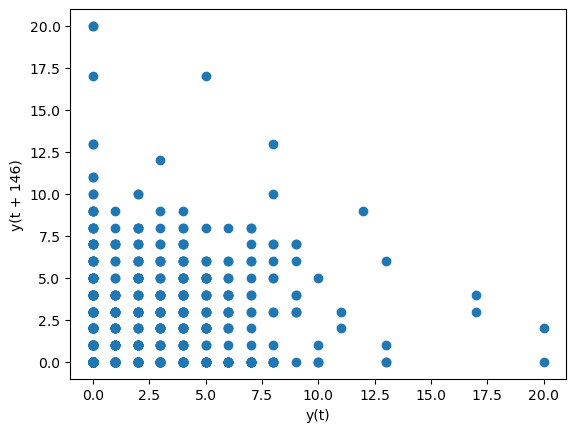

In [84]:
from pandas.plotting import lag_plot

# Make lag plot based on best lag
lag_plot(dft.Count, lag = best_lag)

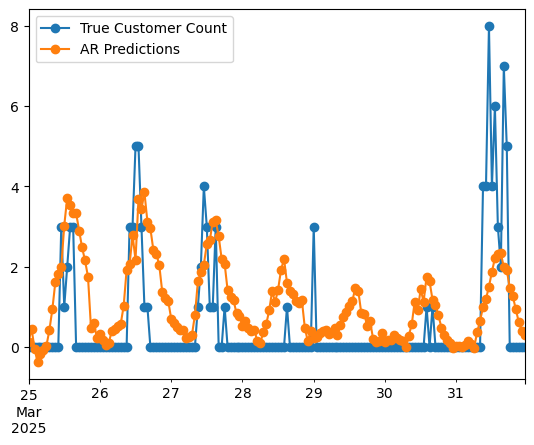

In [80]:
# Train autoregression on the best lag
model = AutoReg(dft_train.Count, lags = best_lag) # input the time series
model_fit = model.fit()

# Predict test week on new model
yhat = model_fit.predict(start='2025-03-25 00:00:00', end='2025-03-31 23:00:00')

# Plot predictions
dft_test["predictions"] = yhat

ax = dft_test.Count.plot(marker='o', label="True Customer Count")
dft_test.predictions.plot(ax=ax, marker='o', label='AR Predictions');
ax.legend();

**Lag Analysis**\
The lag that was found to predict the time series the best was 146. This implies that the last 6 days is the best to\
predict the current counts. Having the best lag be 6 days was not what we were expecting since that means it doesn't use\
the data from the same weekday of the last week.

**Autoregression Analysis**\
The autoregression predicts the Tuesday, Wednesday, and Thursday of the test week fairly well. However, the rest of the\
days as well as the following Monday are not predicted well. 

The oddness in how our data is set up is not helping the autoregression. A majority of the data entries are 0 with only\
the times of when the lab is open and other random times from staff having counts. This leads to the data not being\
incredibly consistent and messes with how the data gets predicted. The counts will also change week by week as certain\
events or assignments come up.

# Ethical Considerations

**Are there any ethical considerations regarding the dataset? (e.g., is it possible the data is biased?)**\
The Team Innovation Lab isn’t open to students on the weekends so the only prints on the weekend are staff. So there is some bias towards staff as they can print throughout the whole week versus students who can only print five days a week.

**Reflect on potential ethical implications of your analysis, such as privacy concerns, fairness, and the societal impact of the model if misused.**\
The Team Innovation Lab isn’t open to students on the weekends so the only prints on the weekend are staff. So there is some bias towards staff as they can print throughout the whole week versus students who can only print five days a week.

**Address ways to mitigate negative impacts of the analysis.**\
We have chosen to not use names after cleaning to avoid privacy issues that could be associated with them. We are just showing our findings in class and to the Team Innovations Lab instead of to the public to mitigate potential copying of ideas.

# Conclusion

- Use a Markdown cell to write a concise conclusion to your analysis. Did your analysis provide insight to this dataset? Were the results expected? If not, why?
- Highlight any limitations encountered.
- Describe at least one possible future direction based on your analysis and dataset. What are the challenges of pursuing this direction? If additional resources/data is needed, please specify.